In [1]:
from desc.compute.utils import get_transforms, get_profiles, get_params, dot, cross
from desc.compute import compute as compute_fun
from desc.backend import jnp
from desc.grid import Grid
import desc.io
import desc.examples
from functools import partial
from jax import jit
from jax.experimental.ode import odeint as jax_odeint
import matplotlib.pyplot as plt
import numpy as np
from desc.equilibrium import Equilibrium

 
eq = desc.io.load("/home/joaobiu/DESC/desc/examples/ct32NFP4_init.h5")
eq._iota = eq.get_profile("iota")
eq._current = None



def rhs(w, t, a):
    
    #initial conditions
    psi, theta, zeta, vpar = w
    
    mu = a[0]

    #obtaining data from DESC   
    keys = ["B", "|B|", "grad(|B|)", "grad(psi)", "e^theta", "e^zeta", "G"] # etc etc, whatever terms you need
    grid = Grid(jnp.array([psi, theta, zeta]).T, jitable=True, sort=False)
    transforms = get_transforms(keys, eq, grid, jitable=True)
    profiles = get_profiles(keys, eq, grid, jitable=True)
    params = get_params(keys, eq)
    data = compute_fun(eq, keys, params, transforms, profiles)
    
    
    psidot = a[1]*(1/data["|B|"]**3)*(mu*data["|B|"] + vpar**2)*jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis=-1) * data["grad(psi)"]) # etc etc
    
    
    thetadot = a[2]*vpar/data["|B|"] * jnp.sum(data["B"] * data["e^theta"]) + (1/data["|B|"]**3)*(mu*data["|B|"] + vpar**2)*jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis=-1) * data["e^theta"])
    
    
    zetadot = a[3]*(vpar/data["|B|"]) * dot(data["B"], data["e^zeta"]) 
    
    b = data["B"]/data["|B|"]

    teste1 = (b + (1/(vpar*data["|B|"]**3)) * (mu*data["|B|"] + vpar**2) * jnp.cross(data["B"], data["grad(|B|)"], axis=-1))
    teste2 = data["grad(|B|)"]
    vpardot = -mu*dot(teste1,teste2)
    #vpardot = -mu*jnp.sum(((data["B"]/data["|B|"])+ (1/vpar*data["|B|"]**3)*(mu*data["|B|"] + vpar**2)*jnp.cross(data["B"], data["grad(|B|)"], axis=-1)) * data["grad(|B|)"])
    
    return jnp.array([psidot, thetadot, zetadot, vpardot]) #, zetadot, vpardot])

DESC version 0+untagged.5332.g4cefce1.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 4.42 GB available memory


In [2]:
initial_conditions = [0.2, 0.2, 0.1, -0.2]
a_initial = [10, 1, 1, 1]

In [6]:
nt_per_time_unit = 10
tmin = 0
tmax = 10
nt = int(nt_per_time_unit * (tmax - tmin))

def solve_with_jax(a=None):
    initial_conditions_jax = jnp.array(initial_conditions, dtype=jnp.float64)
    if a is not None:
        a_jax = a
    else:
        a_jax = jnp.array(a_initial, dtype=jnp.float64)
    t_jax = jnp.linspace(tmin, tmax, nt)
    system_jit = jit(rhs)
    #solution_jax = jax_odeint(system_jit, initial_conditions_jax, t_jax, a_jax)
    solution_jax = jax_odeint(partial(system_jit, a=a_jax), initial_conditions_jax, t_jax)
    return solution_jax

In [7]:
sol = solve_with_jax()

print(sol)

2023-08-29 23:42:48.388935: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m17.12165968s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


[[ 0.2         0.2         0.1        -0.2       ]
 [ 0.20403698  1.65281217  0.07175508 -0.20652786]
 [ 0.20818139  1.61806539  0.0426302  -0.21299271]
 [ 0.21242487  1.58215277  0.0126276  -0.21936324]
 [ 0.21675986  1.54516    -0.01824897 -0.22561349]
 [ 0.22117712  1.50718917 -0.04999431 -0.23171693]
 [ 0.2256655   1.46836481 -0.08260156 -0.2376456 ]
 [ 0.23021174  1.42884131 -0.11606175 -0.24336895]
 [ 0.23480028  1.38881567 -0.15036304 -0.2488523 ]
 [ 0.23941304  1.34854217 -0.1854896  -0.25405492]
 [ 0.24402924  1.30835341 -0.22141996 -0.25892762]
 [ 0.24862532  1.26868804 -0.25812492 -0.26340998]
 [ 0.25317495  1.2301278  -0.29556482 -0.26742725]
 [ 0.25764925  1.19344351 -0.33368613 -0.27088702]
 [ 0.26201722  1.15965628 -0.37241746 -0.27367592]
 [ 0.2662466   1.13011336 -0.41166501 -0.27565694]
 [ 0.27030517  1.10658124 -0.45130768 -0.2766678 ]
 [ 0.27416259  1.09134943 -0.49119216 -0.27652169]
 [ 0.2777929   1.087324   -0.53112882 -0.27501212]
 [ 0.28117767  1.09804652 -0.57

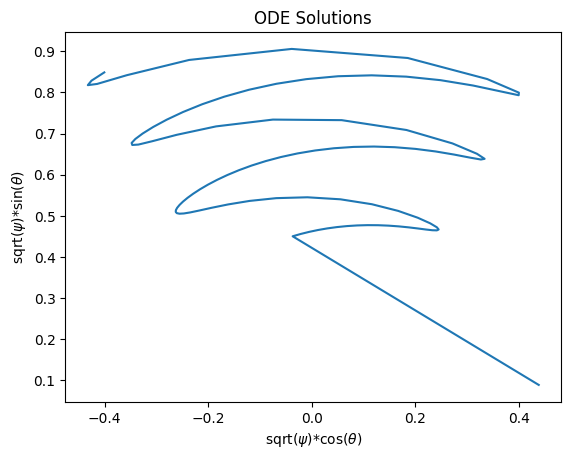

In [8]:
plt.plot(np.sqrt(sol[:, 0]) * np.cos(sol[:, 1]), np.sqrt(sol[:, 0]) * np.sin(sol[:, 1]))
plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.title('ODE Solutions')
plt.show()